# Logistic Model ON Fashion-MINIST

In [1]:
import utils.mnist_reader as mnist_reader
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
seed = 0
np.random.seed(seed)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
X, y = mnist_reader.load_mnist('data/fashion', kind='train')
X_te, y_te = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [3]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=seed, shuffle=True)
print(X_tr.shape, X_val.shape, y_tr.shape, y_val.shape)

(45000, 784) (15000, 784) (45000,) (15000,)


In [4]:
scaler = StandardScaler()
scaler.fit(X)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

In [5]:
param_grid = {
    'penalty': ['elasticnet', 'l1', 'l2', None],
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]
}
training_amount = 15000

In [6]:
logit = LogisticRegression(random_state=seed, n_jobs=-1)
grid_search = RandomizedSearchCV(logit, param_grid, cv=5, random_state=seed, n_jobs=-1)
grid_search.fit(X_tr[:training_amount], y_tr[:training_amount])

/Users/rail_hu/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rail_hu/miniconda3/envs/cs178/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(n_jobs=-1, random_state=0),
                   n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'fit_intercept': [True, False],
                                        'penalty': ['elasticnet', 'l1', 'l2',
                                                    None],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=0)

In [7]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

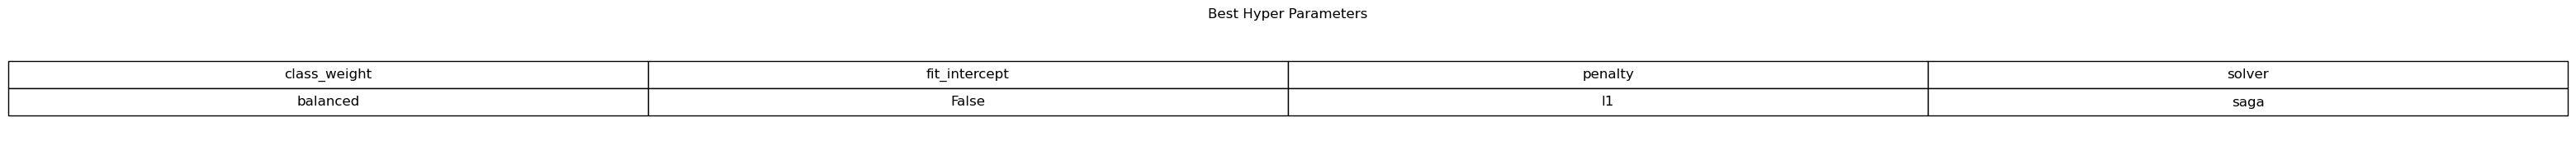

Best Accuracy Score: 0.8493999999999999


In [8]:
fig, ax = plt.subplots(figsize=(20, 2))
ax.axis('off')

table_data = [str(best_params), str(best_score)]

parameter_names = sorted(list(best_params.keys()))
parameter_values = [best_params[key] for key in parameter_names]

table = ax.table(cellText=[parameter_values], colLabels=parameter_names, cellLoc='center', loc='center')

# Set the table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2, 2)

plt.title('Best Hyper Parameters')
plt.show()

print(f'Best Accuracy Score: {best_score}')

In [9]:
df = pd.DataFrame(grid_search.cv_results_)
print(df)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.880557      0.194888         0.225527        0.261149   
1       0.051065      0.006713         0.000000        0.000000   
2      17.998324     16.206998         0.426664        0.499114   
3      66.443758     13.946122         0.013455        0.026911   
4       0.144294      0.180319         0.000000        0.000000   
5      77.951583     16.042036         0.046286        0.022322   
6       0.030934      0.004279         0.000000        0.000000   
7       0.026243      0.001002         0.000000        0.000000   
8       0.039158      0.004498         0.000000        0.000000   
9      59.060994      5.934898         0.009192        0.001250   

      param_solver param_penalty param_fit_intercept param_class_weight  \
0            lbfgs            l2                True           balanced   
1  newton-cholesky            l1               False               None   
2            lbfgs            l2     

In [16]:
cs = [0.1, 0.5, 1, 10, 50, 100, 1000]
tr_errs = []
val_errs = []
te_errs = []

for c in cs:
    logistic = LogisticRegression(solver='saga', class_weight='balanced', fit_intercept = False,\
                                  penalty='l1', C=c, random_state=seed, n_jobs=-1)
    logistic.fit(X_tr[:training_amount], y_tr[:training_amount])

    logistic_train_pred = logistic.predict(X_tr)
    logistic_val_pred = logistic.predict(X_val)
    logistic_test_pred = logistic.predict(X_te)

    logistic_train_error = 1 - accuracy_score(y_tr, logistic_train_pred)
    logistic_val_error = 1 - accuracy_score(y_val, logistic_val_pred)
    logistic_test_error = 1 - accuracy_score(y_te, logistic_test_pred)

    tr_errs.append(logistic_train_error)
    val_errs.append(logistic_val_error)
    te_errs.append(logistic_test_error)

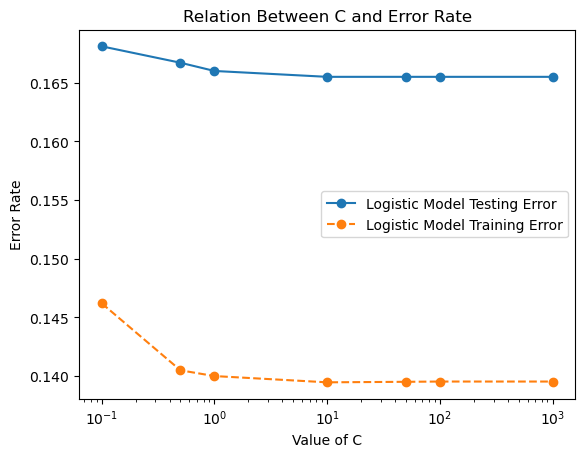

In [17]:
plt.figure()
plt.plot(cs, te_errs, 'o-', label='Logistic Model Testing Error')
plt.plot(cs, tr_errs, 'o--', label='Logistic Model Training Error')

plt.xlabel('Value of C')
plt.ylabel('Error Rate')
plt.xscale('log')
plt.title('Relation Between C and Error Rate')

plt.legend()
plt.show()

In [18]:
print(tr_errs)
print(val_errs)
print(te_errs)

[0.1462, 0.14048888888888889, 0.14, 0.13946666666666663, 0.13951111111111114, 0.1395333333333333, 0.1395333333333333]
[0.15613333333333335, 0.15406666666666669, 0.15333333333333332, 0.1532, 0.15326666666666666, 0.15326666666666666, 0.15326666666666666]
[0.16810000000000003, 0.16669999999999996, 0.16600000000000004, 0.16549999999999998, 0.16549999999999998, 0.16549999999999998, 0.16549999999999998]


In [19]:
tr_errs = []
te_errs = []

n_tr = [100, 1000, 5000, 10000, 20000, 45000]

for n in n_tr:

    # Get a sub portion of feature vectors
    sub_X_tr = X_tr[:n]
    sub_y_tr = y_tr[:n]

    # LogisticRegression
    logistic = LogisticRegression(solver='saga', class_weight='balanced', fit_intercept = False,\
                                  penalty='l1', C=10, random_state=seed, n_jobs=-1)

    logistic.fit(sub_X_tr, sub_y_tr)

    logistic_train_pred = logistic.predict(X_tr)
    logistic_test_pred = logistic.predict(X_te)

    logistic_train_error = 1 - accuracy_score(y_tr, logistic_train_pred)
    logistic_test_error = 1 - accuracy_score(y_te, logistic_test_pred)

    tr_errs.append(logistic_train_error)
    te_errs.append(logistic_test_error)



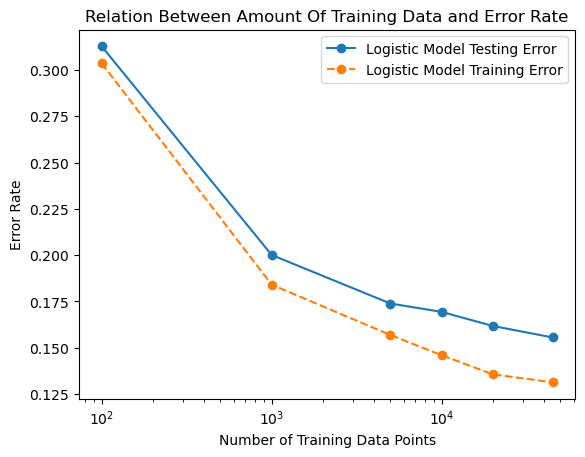

In [20]:
plt.figure()
plt.plot(n_tr, te_errs, 'o-', label='Logistic Model Testing Error')
plt.plot(n_tr, tr_errs, 'o--', label='Logistic Model Training Error')

plt.xlabel('Number of Training Data Points')
plt.ylabel('Error Rate')
plt.xscale('log')
plt.title('Relation Between Amount Of Training Data and Error Rate')

plt.legend()
plt.show()

In [21]:
# model = LogisticRegression(random_state=seed, solver='saga', max_iter=10000)
# model.fit(X_tr, y_tr)

y_tr_pred = logistic.predict(X_tr)
y_val_pred = logistic.predict(X_val)
y_te_pred = logistic.predict(X_te)

acc_tr = accuracy_score(y_tr, y_tr_pred)
acc_val = accuracy_score(y_val, y_val_pred)
acc_te = accuracy_score(y_te, y_te_pred)

print(f"Training Accuracy of Logistic Model: {acc_tr}")
print(f"Validation Accuracy of Logistic Model: {acc_val}")
print(f"Testing Accuracy of Logistic Model: {acc_te}")

Training Accuracy of Logistic Model: 0.8686222222222222
Validation Accuracy of Logistic Model: 0.8542666666666666
Testing Accuracy of Logistic Model: 0.8444


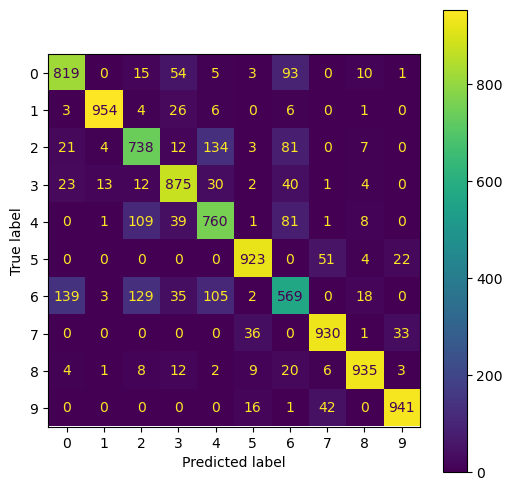

In [22]:
# plot confusion matrix
figure, axes = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(y_te, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(ax=axes)

<Axes: >

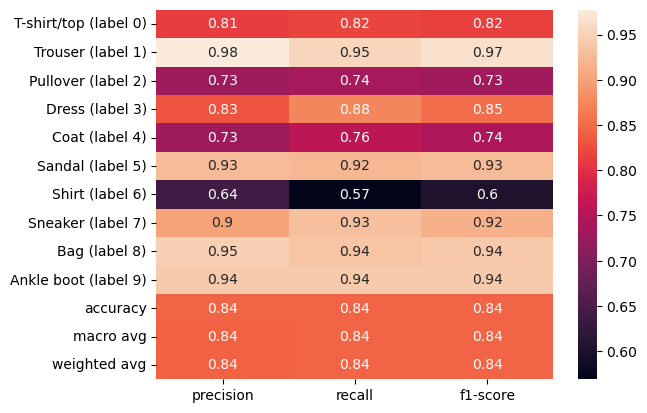

In [23]:
label2desc = {0: 'T-shirt/top (label 0)', 
              1: 'Trouser (label 1)', 
              2: 'Pullover (label 2)', 
              3: 'Dress (label 3)', 
              4: 'Coat (label 4)', 
              5: 'Sandal (label 5)', 
              6: 'Shirt (label 6)', 
              7: 'Sneaker (label 7)',
              8: 'Bag (label 8)',
              9: 'Ankle boot (label 9)'}



report = classification_report(y_te, y_te_pred, target_names = label2desc.values(), output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)